In [14]:
import sys
import pandas as pd
import numpy as np
sys.path.append('../')

# Building batches for training neural nets

Welcome! This is the third tutorial of the series, covering lung cancer research using RadIO. In this tutorial you'll learn about `sample_nodules`-action, that allows to sample interesting parts of scans along with cancerous masks, thus considerably augmenting the dataset for a segmenting net. If you haven't read the first two tutorials, we encourage you to do that before tackling this one. Anyways, here is a quick reminder.

## Not-so-quick reminder

When using RadIO, the first step is always to set up a `Dataset` - a structure (`instance` of a `Dataset`-class), indexing set of voluminous ct-scans on disk:

In [22]:
from radio.dataset import FilesIndex, Dataset
from radio import CTImagesMaskedBatch

LUNA_MASK = '/data/MRT/luna/s*/*.mhd'                                      # set glob-mask for scans from Luna-dataset here
luna_index = FilesIndex(path=LUNA_MASK, no_ext=True)                       # preparing indexing structure
luna_dataset = Dataset(index=luna_index, batch_class=CTImagesMaskedBatch)

Machine learning-solutions always start with preprocessing. RadIO thinks of preprocessing as of chained sequence of actions -  a `Pipeline`. Each `Pipeline` represents a *plan* of what is going to happen with data, rather than a real computation, and is made of actions, implemented in RadIO ([or by you](https://analysiscenter.github.io/lung_cancer/intro/preprocessing.html#writing-your-own-actions)). E.g., you can set up a simple preprocessing pipeline, including `load` from [Luna dataset](https://luna16.grand-challenge.org/)-format and `resize` to shape **[92, 256, 256]** in a following way:

In [2]:
from radio.dataset import Pipeline                 # the cell executes fast
simple_preproc = (Pipeline()                       # we only write a plan
                  .load(fmt='raw')                 # no computations here
                  .resize(shape=(92, 256, 256)))   # it happens later

It might be a good idea to replace `resize` with `unify_spacing`, that not only changes shape of scans, but also zooms them to the same scale:

In [3]:
other_simple_preproc = (Pipeline()
                        .load(fmt='raw')
                        .unify_spacing(shape=(92, 256, 256), spacing=(3.5, 1.0, 1.0)))

You can also add some data-augmenting actions to your pipeline. E.g., `rotate` of scans or cropping out its central part using `central_crop`.

In [4]:
augmenting_pipeline = (Pipeline()
                       .load(fmt='raw')
                       .unify_spacing(shape=(92, 256, 256), spacing=(3.5, 1.0, 1.0))
                       .rotate(angle=30)
                       .central_crop(crop_size=(64, 192, 192)))

You can also get your hands on target for a segmenting net - *cancerous masks*, by adding `fetch_nodules_info` and `create_mask` to a preprocessing pipeline:

In [20]:
nodules_df = pd.read_csv('/data/MRT/luna/CSVFILES/annotations.csv')
nodules_df.head(1)

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471


In [46]:
preprocessing = (Pipeline()
                 .load(fmt='raw')
                 .unify_spacing(shape=(92, 256, 256), spacing=(3.5, 1.0, 1.0))
                 .fetch_nodules_info(nodules_df)
                 .create_mask())

Remember, real computation happens **only** when you pass a part of your `Dataset` - a `Batch` through the workflow: 

In [74]:
batch = (luna_dataset >> preprocessing).next_batch(batch_size=3, shuffle=False)

In [75]:
from utils import get_nodules_pixel_coords
get_nodules_pixel_coords(batch).head(2)

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,1,32,137,77,10
1,1,41,164,207,4


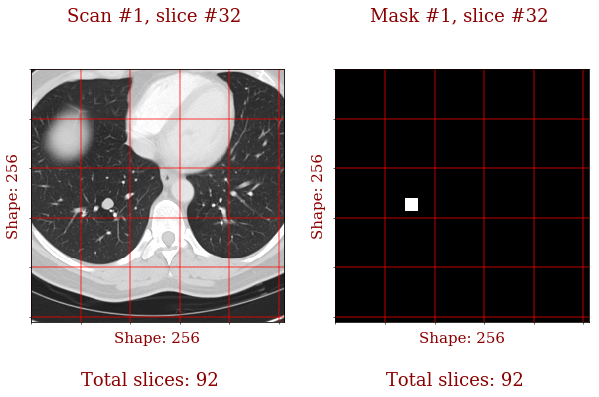

In [77]:
show_slices(batch, 1, [32, 32], components=['images', 'masks'], clims=[(-1200, 300), (0, 1)])

At first glance, nothing stops you now from training a segmenting net on full-sized scans. This, however, would require either a **very fast** CPU or a GPU with **a lot** of memory, as few full-sized scans can fit in, say, 8 GB of 1080 Ti-memory. Consider also the following: frequently, scans of Luna-dataset contain more than one cancerous nodule. What a waste to use a scan like that as only one training example! That being said, it may be a good idea to crop out *parts of scans* and train a net on these parts. Action `sample_nodules` allows you to do just that, as you will see in a minute.

## Sampling batches of crops with `sample_nodules`

### Basic usage

Loaded cancerous masks are necessary requirement for running `sample_nodules`. So, your pipeline should start with something like that:  

In [241]:
preprocessing = (Pipeline()
                 .load(fmt='raw')
                 .unify_spacing(shape=(128, 256, 256), spacing=(3.5, 1.0, 1.0))
                 .fetch_nodules_info(nodules_df)
                 .create_mask())

Say, you want to generate batches of **8** crops of shape **(16, 32, 32)**. You need to simply add `sample_nodules` to your `preprocessing`, specifying `batch_size` and `nodule_size`:

In [245]:
crops_sampling_pipeline = preprocessing.sample_nodules(batch_size=8, nodule_size=(16, 32, 32))

Check out the results by passing a batch of 5 scans through the workflow:

In [240]:
np.random.seed(42)
batch_crops = (luna_dataset >> crops_sampling_pipeline).next_batch(5, shuffle=False)

In [246]:
get_nodules_pixel_coords(batch_crops).head(1)

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,0,8,16,16,10


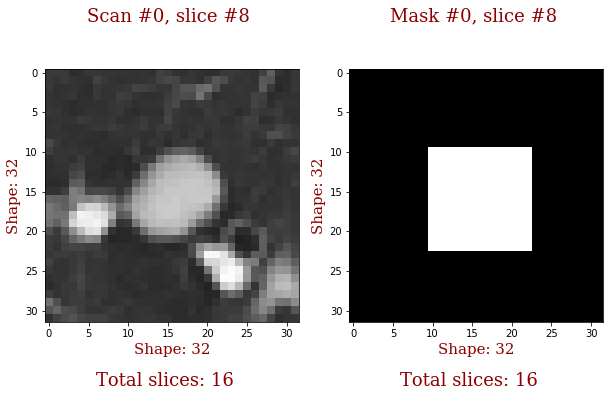

In [247]:
show_slices(batch_crops, 0, 8, components=['images', 'masks'], clims=[(-1200, 300), (0, 1)], grid=False)

### Balancing batches: changing `share` of cancerous crops

You can see that generated batch contains **8** crops: 

In [248]:
len(batch_crops)

8

Still, how much of them contain cancer? Let's find this out by printing number of cancerous pixels in each crop:

In [243]:
from utils import num_of_cancerous_pixels
num_of_cancerous_pixels(batch_crops)

,Scan 0,Scan 1,Scan 2,Scan 3,Scan 4,Scan 5,Scan 6,Scan 7
Number of cancerous pixels:,676,50,25,50,72,72,0,0


Judging by the table above, **six out of eight** crops contain some cancerous pixels. You may want to change the proportion and generate a balanced batch with **half (that is, four out of eight)** of crops being cancerous. For this you only need to set parameter `share` to **0.5**:

In [250]:
crops_sampling_pipeline = preprocessing.sample_nodules(batch_size=8, nodule_size=(16, 32, 32),
                                                       share=(0.5))

In [251]:
batch_crops = (luna_dataset >> crops_sampling_pipeline).next_batch(5, shuffle=False)

There are only **4** crops containing cancer in a generated batch:

In [256]:
num_of_cancerous_pixels(batch_crops)

,Scan 0,Scan 1,Scan 2,Scan 3,Scan 4,Scan 5,Scan 6,Scan 7
Number of cancerous pixels:,2646,50,72,676,0,0,0,0
